# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Helper functions

In [41]:
def plot_matriz_confusao_one_vs_one(y_test, y_pred, model_name, fold_i, flag_normalizado=None):
    """Plota a matriz de confusao comparando cada classe entre si, mostrando as predicoes contra as
    classes verdadeiras.

    Args:
        y_test: serie com os valores verdadeiros
        y_pred: serie com os valores preditos
        flag_normalizado (optional): flag indicando se os valores da matriz de confusao devem ser
        normalizados. Se devem ser normalizados pel. Defaults to None.
    """
    class_names = np.unique(y_pred)

    fig, ax = plt.subplots(figsize=(12, 10))
    cm_plot = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, cmap="flare", normalize=flag_normalizado, ax=ax)
    ax.set_xticklabels(class_names, rotation=45, ha="right");
    cm_plot.figure_.savefig(f"imgs/cm_{model_name}_fold_{fold_i}.png", dpi=300)
    plt.close()
    
    return cm_plot

In [40]:
def stratified_k_fold_grid_search_cv(model, params:dict, X, y, model_name):
    """Realiza o treino e validacao do modelo utilizando StratifiedKFold com GridSearchCV para
    busca dos melhores hiperparametros (tendo assim um nested cross-validation).

    Args:
        model: modelo que se deseja treinar e validar
        params (dict): dicionario com os parametros e seus respectivos valores possiveis para o 
        grid search
        X: features do modelo
        y: coluna de target do modelo
    """
    f1_score_list = []
    melhores_parametros_list = []

    n_splits_k_fold = 5
    n_splits_grid_search = 2

    skf = StratifiedKFold(n_splits=n_splits_k_fold, random_state=4, shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold {i}")
        # separa os dados de treino e teste
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        # inicializa e roda o grid search
        grid_search_cv = GridSearchCV(
            estimator=model, param_grid=params, scoring="f1_weighted", cv=n_splits_grid_search, 
            verbose=3)
        grid_search_cv.fit(X_train, y_train)
        melhores_parametros_list.append(grid_search_cv.best_params_)
        print(f"Melhores parametros grid search: {grid_search_cv.best_params_}")
        # com os melhores parametros encontrados, realiza a predicao no fold de teste e calcula a 
        # metrica de avaliacao
        y_pred = grid_search_cv.predict(X_test)
        f1_score_value = f1_score(y_test, y_pred, average='weighted')
        f1_score_list.append(f1_score_value)
        print(f"F1 score = {f1_score_value:.3f}")
        # gera a matriz de confusao e salva
        plot_matriz_confusao_one_vs_one(y_test, y_pred, model_name, i, flag_normalizado="true")
        

    f1_score_list = np.array(f1_score_list)
    print("\nResultados finais:\n")
    print(f"F1 score médio = {f1_score_value.mean():.3f}")
    for n_fold, melhores_parametros, f1_score_value in zip(
        range(1,11), melhores_parametros_list, f1_score_list
    ):
        print(
            f"Fold {n_fold} - Melhores parametros: {melhores_parametros} | F1 score: "
            f"{f1_score_value:.3f}"
        )

# Carrega dados

In [5]:
raw_data = loadarff('data/dataset.arff')
df_data = pd.DataFrame(raw_data[0])
df_data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,11.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
3,4.0,1.0,0.0,0.0,1.0,6.0,1.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0,58.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,22.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,b'Class_1'


In [6]:
# decodifica string de target
df_data["target"] = df_data["target"].str.decode("utf-8")

In [7]:
df_data.shape

(61878, 95)

In [8]:
df_data["target"].value_counts()

target
Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: count, dtype: int64

In [9]:
df_data.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,0.263906,1.252869,0.140874,0.480979,1.696693,1.284398,1.413459,0.366108,0.575423,0.551699,0.471525,0.204014,0.729969,0.142522,2.643880,1.534520,0.563108,0.696613,0.238970,0.275768,0.150312,0.148680,1.043796,0.696516,0.946411,0.666263,0.709089,0.263632,0.582129,0.485585,1.653059,0.303468,0.698019,0.451146,0.560829,0.238130,0.641375,0.249669,1.584893,0.348314,0.324283,0.053298,0.213485,0.442063,2.072465,0.323120,0.303775,0.309108,0.697970,0.388603,1.029930,0.239746,1.187563,0.168590,1.256796,0.222228,0.571706,2.897653,0.392902,0.811128,0.892789,0.319290,0.858722,0.591050,0.579851,0.726817,0.748457,0.124196,0.366415,0.300446,0.698067,0.078461,0.187983,0.496719,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,1.083340,3.042333,0.567089,2.014697,3.163212,3.862236,2.226163,1.477436,1.335985,4.636145,1.438727,0.696050,1.446220,0.782979,4.629015,2.332994,1.710305,2.873222,0.828112,1.901294,1.640880,0.897354,2.416849,1.310202,3.368622,3.197965,2.555119,0.756934,1.602579,3.298315,3.299798,1.085672,1.961189,1.706013,1.346090,2.587131,2.348359,1.446203,2.577071,1.369380,1.720470,0.513820,1.044788,2.006485,4.113319,0.998743,1.925806,1.082148,3.983722,2.577693,3.028469,1.017553,2.666742,0.946158,3.402080,0.783052,1.361874,4.974322,1.761054,4.111091,1.941368,1.162443,2.411646,5.783233,3.757822,3.200095,2.920038,0.906621,2.778317,1.285569,2.245671,0.461244,0.836269,2.434921,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

# Modelos

In [10]:
X = df_data.drop(columns=["id", "target"])
y = df_data[["target"]]

In [42]:
# define os parametros e seus respectivos valores a serem testados no grid search
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "class_weight": ["balanced", None]
}
# define o modelo
model = DecisionTreeClassifier(random_state=4)
# chama a funcao que roda o stratified k fold e valida o modelo realizando a busca por hiper 
# parametros com grid search cv, fazendo assim um nested cross-validation
print("Modelo: DecisionTree")
stratified_k_fold_grid_search_cv(model, params, X, y, "DecisionTree")

Modelo: DecisionTree


Fold 0
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END class_weight=balanced, criterion=gini;, score=0.679 total time=   1.5s
[CV 2/2] END class_weight=balanced, criterion=gini;, score=0.681 total time=   1.7s
[CV 1/2] END class_weight=balanced, criterion=entropy;, score=0.679 total time=   1.9s
[CV 2/2] END class_weight=balanced, criterion=entropy;, score=0.672 total time=   1.4s
[CV 1/2] END class_weight=balanced, criterion=log_loss;, score=0.679 total time=   1.4s
[CV 2/2] END class_weight=balanced, criterion=log_loss;, score=0.672 total time=   1.4s
[CV 1/2] END .class_weight=None, criterion=gini;, score=0.687 total time=   1.2s
[CV 2/2] END .class_weight=None, criterion=gini;, score=0.693 total time=   1.4s
[CV 1/2] END class_weight=None, criterion=entropy;, score=0.685 total time=   1.4s
[CV 2/2] END class_weight=None, criterion=entropy;, score=0.690 total time=   1.2s
[CV 1/2] END class_weight=None, criterion=log_loss;, score=0.685 total time=   1.1s
[CV

# Testes Confusion Matrix

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, stratify=y)
model = DecisionTreeClassifier(random_state=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

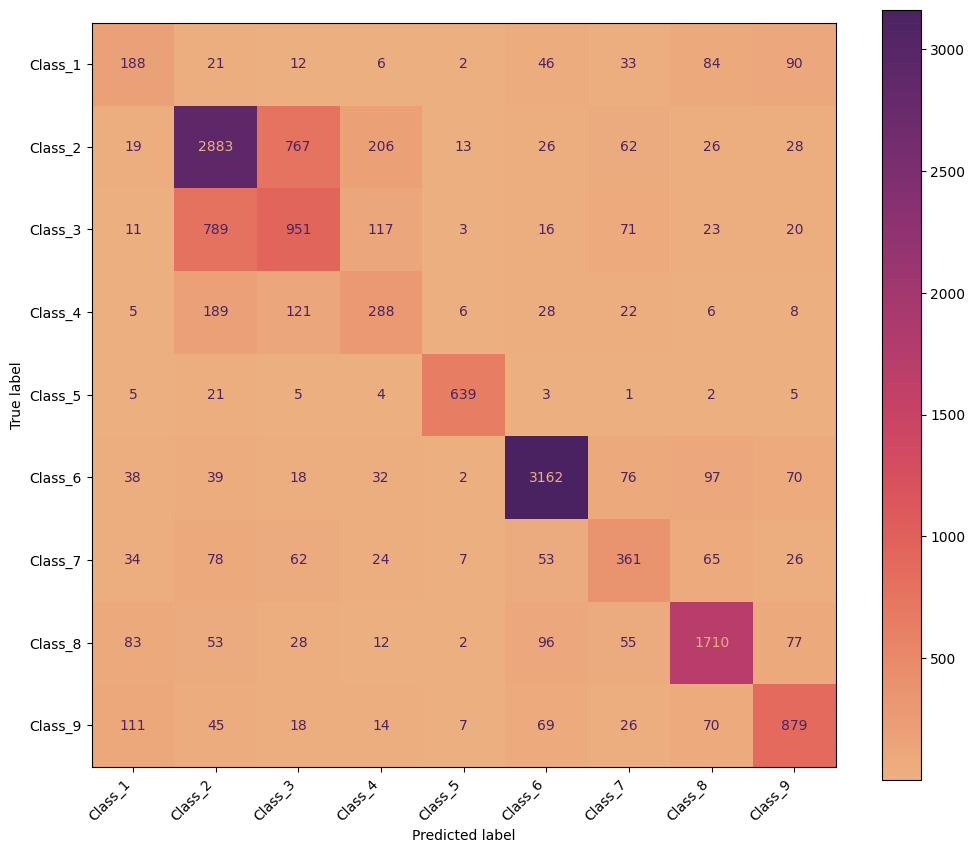

In [35]:
plot_matriz_confusao_one_vs_one(y_test, y_pred, flag_normalizado=None)

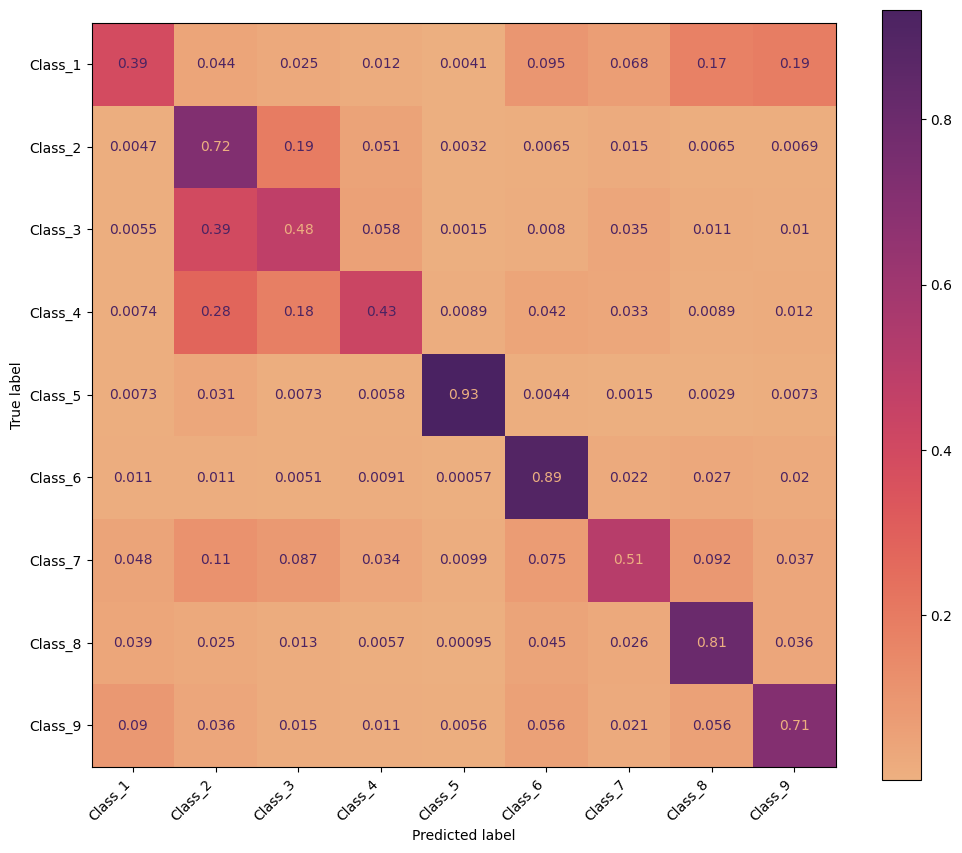

In [30]:
#fig = plt.figure(figsize=(16, 14))
fig, ax = plt.subplots(figsize=(12, 10))
class_names = np.unique(y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="flare", normalize="true", ax=ax)
ax.set_xticklabels(class_names, rotation=45, ha="right");

In [33]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[11768,   222],
        [  213,   173]],

       [[ 8169,   952],
        [  948,  2307]],

       [[ 9851,   886],
        [  842,   797]],

       [[11497,   344],
        [  306,   229]],

       [[11813,    37],
        [   21,   505]],

       [[ 9233,   253],
        [  337,  2553]],

       [[11519,   289],
        [  311,   257]],

       [[10409,   304],
        [  309,  1354]],

       [[11223,   239],
        [  239,   675]]])

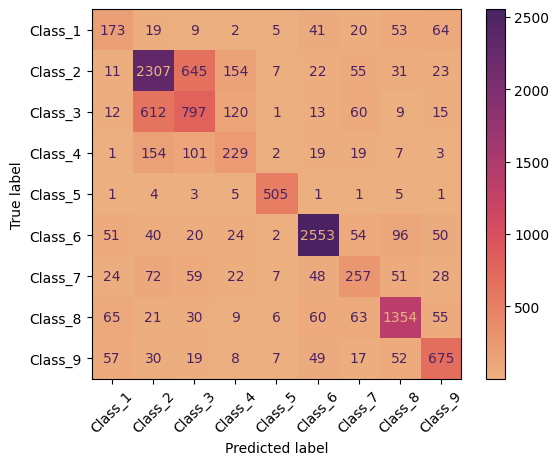

In [50]:
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="flare", xticks_rotation=45)

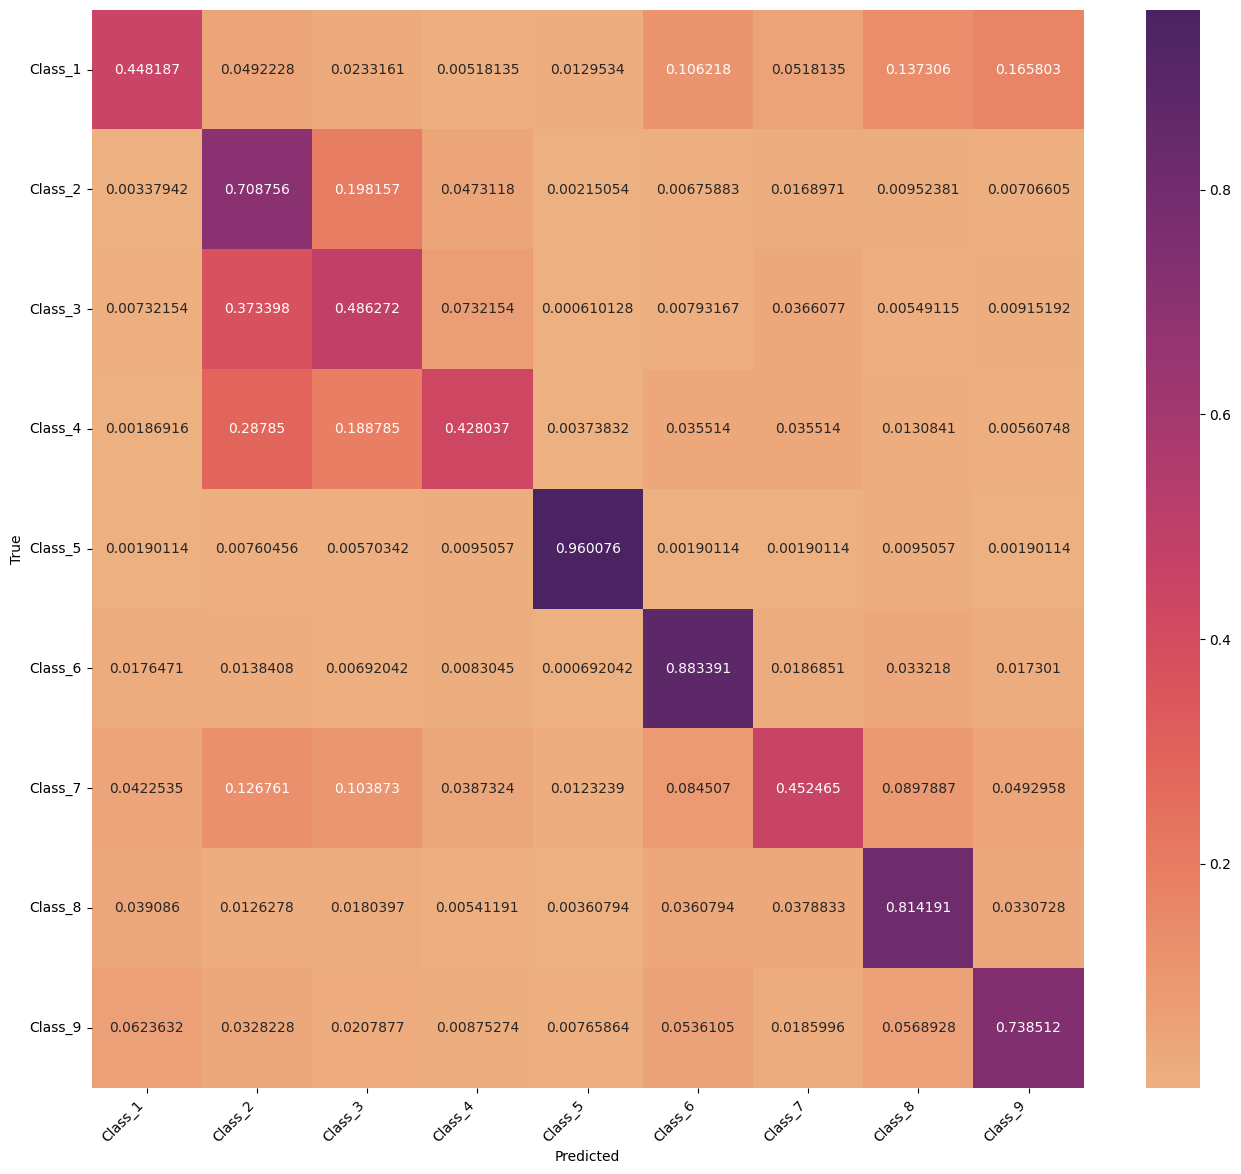

In [41]:
plot_matriz_confusao_one_vs_one(y_test, y_pred, "true")